
# Dialect classification

### Install and import necessary packages

In [2]:
!pip install transformers seqeval[gpu]
!pip install datasets
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.3 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 596 kB 46.8 MB/s 
     |████████████████████████████████| 6.6 MB 52.7 MB/s 
     |████████████████████████████████| 101 kB 10.9 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=87a929e46e784db51134f4e446127cf93263d912102004f494db3bab1b3b2cb2
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 4.2 MB/s 
     |█████████████████

In [3]:
import torch
import numpy as np
import pandas as pd
import datasets
from collections import Counter
from datasets import load_dataset
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Load data

#### import data

In [4]:
torch.cuda.is_available()
device = torch.device("cuda")
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/MyDrive/eth_CS4NLP/project/qadata'
train_path = '/content/drive/MyDrive/eth_CS4NLP/project/qadata/vardial_train_2.csv'
dev_path = '/content/drive/MyDrive/eth_CS4NLP/project/qadata/vardial_dev.txt'

Mounted at /content/drive
vardial_dev.gdoc  vardial_train_1.csv  vardial_train.gsheet
vardial_dev.txt   vardial_train_2.csv


In [5]:
#IMPORT devset
dial_label = {
    0 : 'EML',
    1 : 'NAP',
    2 : 'PMS',
    3 : 'FUR',
    4 : 'LLD',
    5 : 'LIJ',
    6 : 'LMO',
    7 : 'ROA_TARA',
    8 : 'SCN', 
    9 : 'VEC',
    10 : 'SC'
}

fold_label = {
    'EML' : 0,
    'NAP' : 1,
    'PMS' : 2,
    'FUR' : 3,
    'LLD' : 4,
    'LIJ' : 5,
    'LMO' : 6,
    'ROA_TARA' : 7,
    'SCN' : 8,
    'VEC' : 9,
    'SC' : 10
}

def explain_label(label : int) -> str:
    """ 
    Given an integer label, convert it to the corresponding string label
    :param int label: integer label to be converted
    :return: string corresponding to the given label
    """
    return dial_label[label]

def encode_label(label : str) -> int:
    """ 
    Given a string label, encode it to the corresponding index
    :param string label: string label to be converted
    :return: int corresponding to the given label
    """
    return fold_label[label]

In [6]:
df_dev = pd.read_csv(dev_path, sep = "\t", names=["label", "text"])
df_dev['label'] = df_dev['label'].apply(encode_label)
df_dev = df_dev.fillna('')
#-
df_train = pd.read_csv(train_path)
df_train_=df_train[['text','label']]
df_train_.drop_duplicates(subset ='text',keep = False, inplace = True, ignore_index=True) 
#SUBSET
#f_train_ = df_train_.iloc[0:1000,:] 

In [7]:
df_train_.head(2)

,text,label
0,Al funsiòuna da 'l 11 ed novèmber dal 2016.,0
1,Al 2017 'l è 'n an dal XXI sécol dal Calendàr...,0


In [8]:
# Create dictionaries to transform from labels to id and vice-versa.
id2label = {0 : 'EML',
    1 : 'NAP',
    2 : 'PMS',
    3 : 'FUR',
    4 : 'LLD',
    5 : 'LIJ',
    6 : 'LMO',
    7 : 'ROA_TARA',
    8 : 'SCN', 
    9 : 'VEC',
    10 : 'SC'}
label2id = {v:k for k,v in id2label.items()}
num_labels = len(id2label)
print(id2label)

{0: 'EML', 1: 'NAP', 2: 'PMS', 3: 'FUR', 4: 'LLD', 5: 'LIJ', 6: 'LMO', 7: 'ROA_TARA', 8: 'SCN', 9: 'VEC', 10: 'SC'}


In [9]:
from datasets import Dataset
train_ds = Dataset.from_pandas(df_train_)
dev_ds = Dataset.from_pandas(df_dev)
# Example of instance of the dataset
train_ds[18]

{'label': 0,
 'text': "Una gita scolastica  all'è un film dal 1983 dirigì da Pupi Avati."}

In [10]:
'''train_data = pd.read_csv(train_data_path)
X_train = train_data['text']
y_train = train_data['label'].astype(int)

sent_X_train = []
sent_y_train = []
for i, article in enumerate(X_train):
  for sentence in sent_tokenize(article):
    sent_X_train.append(sentence)
    sent_y_train.append(y_train[i])

sent_X_train = pd.DataFrame(sent_X_train)
sent_y_train = pd.DataFrame(sent_y_train)


train_df = pd.concat([sent_X_train, sent_y_train], axis = 1)
train_df.columns = ['text', 'label']
train_dataset = Dataset.from_pandas(train_df)'''

"train_data = pd.read_csv(train_data_path)\nX_train = train_data['text']\ny_train = train_data['label'].astype(int)\n\nsent_X_train = []\nsent_y_train = []\nfor i, article in enumerate(X_train):\n  for sentence in sent_tokenize(article):\n    sent_X_train.append(sentence)\n    sent_y_train.append(y_train[i])\n\nsent_X_train = pd.DataFrame(sent_X_train)\nsent_y_train = pd.DataFrame(sent_y_train)\n\n\ntrain_df = pd.concat([sent_X_train, sent_y_train], axis = 1)\ntrain_df.columns = ['text', 'label']\ntrain_dataset = Dataset.from_pandas(train_df)"

## Tokenizing data

In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

#### model_name
- [x] m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0
- [x] 'dbmdz/bert-base-italian-cased'
- [x] 'dbmdz/bert-base-italian-xxl-cased'
- [x] 'dbmdz/bert-base-italian-uncased'
- [x] mrm8488/bert-italian-finedtuned-squadv1-it-alfa

In [27]:

# Load BERT tokenizer.
model_name = 'mrm8488/bert-italian-finedtuned-squadv1-it-alfa'


In [28]:
#tokenizer = XLNetTokenizer.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

https://huggingface.co/mrm8488/bert-italian-finedtuned-squadv1-it-alfa/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpy9_r40jw


Downloading:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

storing https://huggingface.co/mrm8488/bert-italian-finedtuned-squadv1-it-alfa/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/d7bde0389fdf35cd8d09cc5302592b584893f01a8b05a1ac614cd7f8d65874e6.f19de0c372e9b00104464e8b09d5fbbdd67565d0e0af78462fb22d8f5d2c1fe1
creating metadata file for /root/.cache/huggingface/transformers/d7bde0389fdf35cd8d09cc5302592b584893f01a8b05a1ac614cd7f8d65874e6.f19de0c372e9b00104464e8b09d5fbbdd67565d0e0af78462fb22d8f5d2c1fe1
https://huggingface.co/mrm8488/bert-italian-finedtuned-squadv1-it-alfa/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp5b5wjswh


Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

storing https://huggingface.co/mrm8488/bert-italian-finedtuned-squadv1-it-alfa/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/3993d51897b16eb991f4f22b348e18e573a71c5e096482a247a8a86539509eaf.c453b518dfbcb3c8e3f3e1d1c997e61aeb83a48eb1a7baea9a608685cfb507df
creating metadata file for /root/.cache/huggingface/transformers/3993d51897b16eb991f4f22b348e18e573a71c5e096482a247a8a86539509eaf.c453b518dfbcb3c8e3f3e1d1c997e61aeb83a48eb1a7baea9a608685cfb507df
loading configuration file https://huggingface.co/mrm8488/bert-italian-finedtuned-squadv1-it-alfa/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3993d51897b16eb991f4f22b348e18e573a71c5e096482a247a8a86539509eaf.c453b518dfbcb3c8e3f3e1d1c997e61aeb83a48eb1a7baea9a608685cfb507df
Model config BertConfig {
  "_name_or_path": "mrm8488/bert-italian-finedtuned-squadv1-it-alfa",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": 

Downloading:   0%|          | 0.00/230k [00:00<?, ?B/s]

storing https://huggingface.co/mrm8488/bert-italian-finedtuned-squadv1-it-alfa/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/2d58f90ba360aa15c5fa96222a159a82e0142b631d4de926592738c6dd8d2911.83ca512ab51c5bc2809e83002a054b84ab85a200b98d5c0eb036d7611ee4362e
creating metadata file for /root/.cache/huggingface/transformers/2d58f90ba360aa15c5fa96222a159a82e0142b631d4de926592738c6dd8d2911.83ca512ab51c5bc2809e83002a054b84ab85a200b98d5c0eb036d7611ee4362e
https://huggingface.co/mrm8488/bert-italian-finedtuned-squadv1-it-alfa/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp92njn_hq


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

storing https://huggingface.co/mrm8488/bert-italian-finedtuned-squadv1-it-alfa/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/ebbf0ebbd38988acd68d236b51a7d204ff847ed93a7b0f784d8c66d00a5663ad.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
creating metadata file for /root/.cache/huggingface/transformers/ebbf0ebbd38988acd68d236b51a7d204ff847ed93a7b0f784d8c66d00a5663ad.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/mrm8488/bert-italian-finedtuned-squadv1-it-alfa/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/2d58f90ba360aa15c5fa96222a159a82e0142b631d4de926592738c6dd8d2911.83ca512ab51c5bc2809e83002a054b84ab85a200b98d5c0eb036d7611ee4362e
loading file https://huggingface.co/mrm8488/bert-italian-finedtuned-squadv1-it-alfa/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/mrm8488/bert-italian-finedtuned-squadv1-it-alfa/resol

In [29]:

def encode_dataset(dataset: datasets.arrow_dataset.Dataset) -> list:
  '''
  Transforming each instance of the dataset with the Tokenizer
  '''
  encoded_dataset = []
  for item in dataset:
    # Tokenize the sentence.
    sentence_encoded = tokenizer(item['text'],
                                return_tensors="pt", 
                                padding='max_length', 
                                truncation=True, 
                                max_length=50)
    
    sentence_encoded['labels'] = torch.LongTensor(np.array([item['label']]))
    encoded_dataset.append(sentence_encoded)

  # Reduce dimensionality of tensors.
  for item in encoded_dataset:
    for key in item:
      item[key] = torch.squeeze(item[key])
  return encoded_dataset

In [30]:
# Tokenizing datasets
encoded_dataset_train = encode_dataset(train_ds)
encoded_dataset_test = encode_dataset(dev_ds)

In [31]:
'''# Example of dataset
for token, token_label in zip(tokenizer.convert_ids_to_tokens(encoded_dataset_train[50]["input_ids"]), encoded_dataset_train[50]["input_ids"]):
  print('{0:10}  {1}'.format(token, token_label))'''

'# Example of dataset\nfor token, token_label in zip(tokenizer.convert_ids_to_tokens(encoded_dataset_train[50]["input_ids"]), encoded_dataset_train[50]["input_ids"]):\n  print(\'{0:10}  {1}\'.format(token, token_label))'

# Fine tunning of the model

In [32]:
# Common training arguments
training_args = TrainingArguments(
    num_train_epochs=2,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    logging_dir='logs',
    no_cuda=False,  
    output_dir = 'drive/MyDrive/eth_CS4NLP/project',
)

# Dictionary to save the results
models_performance ={}

# FINE TUNING PROCESS

# create model
#model = XLNetForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

'''model.transformer.mask_emb.requires_grad = False
model.transformer.word_embedding.weight.requires_grad = False
for name, param in model.transformer.layer.named_parameters():
  try:
    layer = int(name[:2])
  except ValueError:
    try:
      layer = int(name[:1])
    except ValueError:
      layer = 0
  if layer <= 20:
    param.requires_grad = False'''


# Create trainer
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=encoded_dataset_train,)

# Fine tunning
trainer.train()


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/mrm8488/bert-italian-finedtuned-squadv1-it-alfa/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3993d51897b16eb991f4f22b348e18e573a71c5e096482a247a8a86539509eaf.c453b518dfbcb3c8e3f3e1d1c997e61aeb83a48eb1a7baea9a608685cfb507df
Model config BertConfig {
  "_name_or_path": "mrm8488/bert-italian-finedtuned-squadv1-it-alfa",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

storing https://huggingface.co/mrm8488/bert-italian-finedtuned-squadv1-it-alfa/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/f1fef89a7f4cb87b1251c38f722c22562b3b3747a2e0ef85c48656389a4effc6.3758fc1896e8ef6b5624123e4932c0c9f32105c6ac03c969473161e304849dc8
creating metadata file for /root/.cache/huggingface/transformers/f1fef89a7f4cb87b1251c38f722c22562b3b3747a2e0ef85c48656389a4effc6.3758fc1896e8ef6b5624123e4932c0c9f32105c6ac03c969473161e304849dc8
loading weights file https://huggingface.co/mrm8488/bert-italian-finedtuned-squadv1-it-alfa/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/f1fef89a7f4cb87b1251c38f722c22562b3b3747a2e0ef85c48656389a4effc6.3758fc1896e8ef6b5624123e4932c0c9f32105c6ac03c969473161e304849dc8
Some weights of the model checkpoint at mrm8488/bert-italian-finedtuned-squadv1-it-alfa were not used when initializing BertForSequenceClassification: ['qa_outputs.bias', 'qa_outputs.weight']
- This IS expected

Step,Training Loss
500,0.321800
1000,0.118300
1500,0.096000
2000,0.083700
2500,0.078700
3000,0.071800
3500,0.045600


Saving model checkpoint to drive/MyDrive/eth_CS4NLP/project/checkpoint-500
Configuration saved in drive/MyDrive/eth_CS4NLP/project/checkpoint-500/config.json
Model weights saved in drive/MyDrive/eth_CS4NLP/project/checkpoint-500/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/eth_CS4NLP/project/checkpoint-500/tokenizer_config.json
Special tokens file saved in drive/MyDrive/eth_CS4NLP/project/checkpoint-500/special_tokens_map.json
Saving model checkpoint to drive/MyDrive/eth_CS4NLP/project/checkpoint-1000
Configuration saved in drive/MyDrive/eth_CS4NLP/project/checkpoint-1000/config.json
Model weights saved in drive/MyDrive/eth_CS4NLP/project/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/eth_CS4NLP/project/checkpoint-1000/tokenizer_config.json
Special tokens file saved in drive/MyDrive/eth_CS4NLP/project/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to drive/MyDrive/eth_CS4NLP/project/checkpoint-1500
Configuration saved i

Step,Training Loss
500,0.321800
1000,0.118300
1500,0.096000
2000,0.083700
2500,0.078700
3000,0.071800
3500,0.045600
4000,0.046200
4500,0.041100
5000,0.040600


Saving model checkpoint to drive/MyDrive/eth_CS4NLP/project/checkpoint-4000
Configuration saved in drive/MyDrive/eth_CS4NLP/project/checkpoint-4000/config.json
Model weights saved in drive/MyDrive/eth_CS4NLP/project/checkpoint-4000/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/eth_CS4NLP/project/checkpoint-4000/tokenizer_config.json
Special tokens file saved in drive/MyDrive/eth_CS4NLP/project/checkpoint-4000/special_tokens_map.json
Saving model checkpoint to drive/MyDrive/eth_CS4NLP/project/checkpoint-4500
Configuration saved in drive/MyDrive/eth_CS4NLP/project/checkpoint-4500/config.json
Model weights saved in drive/MyDrive/eth_CS4NLP/project/checkpoint-4500/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/eth_CS4NLP/project/checkpoint-4500/tokenizer_config.json
Special tokens file saved in drive/MyDrive/eth_CS4NLP/project/checkpoint-4500/special_tokens_map.json
Saving model checkpoint to drive/MyDrive/eth_CS4NLP/project/checkpoint-5000
Configuration sa

TrainOutput(global_step=6076, training_loss=0.0841549084404725, metrics={'train_runtime': 3459.8663, 'train_samples_per_second': 224.738, 'train_steps_per_second': 1.756, 'total_flos': 1.99806338296986e+16, 'train_loss': 0.0841549084404725, 'epoch': 2.0})

In [33]:
# Get the predicted labels
preds = trainer.predict(encoded_dataset_test)
predictions = preds.predictions.argmax(-1)

# Create array with predicted labels and expected.
true_values = np.array(preds.label_ids).flatten()
predicted_values = np.array(preds.predictions.argmax(-1)).flatten()

# Filter the labels. We only produce a label for each word. We filter labels
# of subwords and special tokens, such as PAD
proc_predicted_values = [prediction for prediction, label in zip(predicted_values, true_values) if label != -100]
proc_true_values = [label for prediction, label in zip(predicted_values, true_values) if label != -100]

# Evaluate models
model_performance = {}
model_performance['accuracy'] = accuracy_score(proc_true_values, proc_predicted_values)
model_performance['precision_micro'] = precision_score(proc_true_values, proc_predicted_values, average='micro')
model_performance['precision_macro'] = precision_score(proc_true_values, proc_predicted_values, average='macro')
model_performance['recall_micro'] = recall_score(proc_true_values, proc_predicted_values, average='micro')
model_performance['recall_macro'] = recall_score(proc_true_values, proc_predicted_values, average='macro')
model_performance['f1_micro'] = f1_score(proc_true_values, proc_predicted_values, average='micro')
model_performance['f1_macro'] = f1_score(proc_true_values, proc_predicted_values, average='macro')

model_performance['confusion_matrix'] = confusion_matrix(proc_true_values, proc_predicted_values)
model_performance['confusion_matrix_normalized'] = confusion_matrix(proc_true_values, proc_predicted_values, normalize='true')

***** Running Prediction *****
  Num examples = 6801
  Batch size = 128


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
model_performance

{'accuracy': 0.8829583884722835,
 'confusion_matrix': array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0, 1175,    0,    1,    2,   11,    0,    0,    2,    0],
        [   0,    0,    1,  670,    0,    1,    1,    0,    1,    2,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,  598,   19,    0,    0,    0,    0],
        [   2,    9,    3,    3,    2,    9, 1166,    0,   11,   18,    8],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0,   29,    2,    0,    0,    6,   20,    0, 1282,    5,   28],
        [   0,   27,    7,    1,    2,   51,  401,    1,    7,  723,   17],
        [   0,    2,    2,    1,    1,   14,    8,    0,   58,    0,  391]]),
 'confusion_matrix_normalized': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
     

# Models evaluation

F1-micro and F1-macro for each model

In [35]:
print('------------Model performance------------')
print(f'  accuracy: {model_performance["accuracy"]}')
print(f'  f1-micro: {model_performance["f1_micro"]}')
print(f'  f1-macro: {model_performance["f1_macro"]}')
print()

------------Model performance------------
  accuracy: 0.8829583884722835
  f1-micro: 0.8829583884722834
  f1-macro: 0.5665594632455235



To understan better the performance of the classifier, we display the confusion matrix:

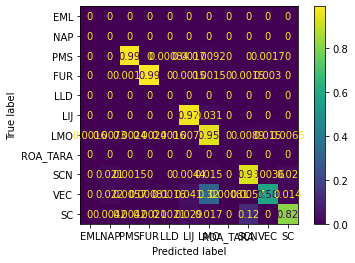

In [36]:
disp = ConfusionMatrixDisplay(confusion_matrix=model_performance['confusion_matrix_normalized'],display_labels = list(id2label.values()))
disp.plot()

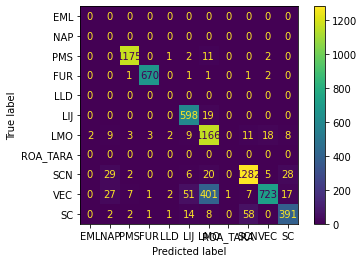

In [37]:
disp = ConfusionMatrixDisplay(confusion_matrix=model_performance['confusion_matrix'],display_labels = list(id2label.values()))
disp.plot()

In [38]:
pred_df = pd.DataFrame({'pred_label':predicted_values})
pred_df

,pred_label
0,6
1,8
2,6
3,9
4,5
...,...
6796,9
6797,8
6798,8
6799,8


In [39]:
df_dev.shape

(6801, 2)

In [41]:
from google.colab import files
pred_df.to_csv('pred_bert_mrm8488_bert-italian-finedtuned-squadv1-it-alfa.csv',index=False)
files.download('pred_bert_mrm8488_bert-italian-finedtuned-squadv1-it-alfa.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>